# CH3: Classification, 뒷부분

In [1]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""

    labels_path = os.path.join('/Users/WooJin/Documents/ML_study/MNIST_data',
                               '%s-labels-idx1-ubyte'
                               % kind)

    images_path = os.path.join('/Users/WooJin/Documents/ML_study/MNIST_data',
                                '%s-images-idx3-ubyte'
                                % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

X_train, y_train = load_mnist('mnist', kind='train')
print('Rows: %d, columns: %d'
        % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d'
      % (X_test.shape[0], X_test.shape[1]))


import matplotlib.pyplot as plt

Rows: 60000, columns: 784
Rows: 10000, columns: 784


## Multiclass Classification

Random forest, naive Bayes와 같은 분류기는 여러 클래스를 직접 분류할 수 있다. SVM혹은 선형모델은 바이너리 분류기다. 하지만 여러개의 바이너리 분류기를 사용해 multiclass를 분류할 수도 있다. 예를 들어 0~9까지 숫자를 분류한다면 10개의 바이너리 분류기를 사용하는 것이다(One-versus-all method)

다른 방법은 매 쌍의 숫자들에 대해 분류기를 학습시키는 것이다. 하나는 0과 1을 구분하고, 하나는 0,2 이런 식으로. 이는 one-versus-one 전략이다. 이를 쓴다면 만약 N개의 클래스를 구분하려면 N*(N-1)/2개의 분류기가 필요하다(n combination 2니까). 이것의 장점은 구분되어야 할 다른 클래스들만 따로 학습시킬 수 있는 것이다.

SVM과 같은 알고리즘은 training set 사이즈가 커지는 만큼 성능이 잘 좋아지지는 않아서 이러한 것들은 OvO로 작은 트레이닝 셋들로 쪼개 학습시키는게 효율적이다.(보통은 큰거에 분류기 몇개 있음) 하지만 대부분 OvA가 더 효율적이다.

scikit-learn에 binary 분류 알고리즘은 자동적으로 OvA를 쓴다(SVM 빼고).

In [2]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5 )
some_digit = X_train[9]


from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

In [3]:
y_train[9]

4

In [4]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-397265.2990347 , -352024.67184176, -110146.9999803 ,
        -531668.98364427,  368445.13012962, -222203.30605404,
        -299454.92005662, -360950.660888  , -294064.33069836,
        -224444.45097992]])

In [5]:
np.argmax(some_digit_scores)

4

In [6]:
sgd_clf.classes_
sgd_clf.classes_[4]

4

ScikitLearn에서 OvO or OvA를 지정하고 싶다면, OneVsOneClassifier or OneVsRestClassifier 클래스를 쓰면 된다. 다음과 같이 만들 수 있다.

In [7]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42)) #여기에 RandomForest써도 ok
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4], dtype=uint8)

In [8]:
len(ovo_clf.estimators_)

45

In [9]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 43)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([4], dtype=uint8)

여기서는 따로 OvA나 OvO를 실행할 필요가 없다. RF 분류기는 바로 인스턴스들을 multiple class로 분류할 수 있기 때문이다. 

In [10]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86872625,  0.87639382,  0.87848177])

단순히 scale을 해주는 것 만으로도 성능을 올릴 수 있다.

In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90736853,  0.90884544,  0.91363705])

## Error analysis

여기서는 이미 잘되는 모델을 찾았고, 이를 어떻게 향상시키는지 배운다. 한가지 방법은 어떠한 타입의 에러가 나는지 확인하는 것이다.

첫번째로, confusion matrix를 확인한다. cross_val_predict()함수를 이용해 예측을 하고, confusion_matrix() 함수를 부른다.

**Confusion matrix**:In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix,[4] is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each column of the matrix represents the instances in a predicted class while each row represents the instances in an actual class (or vice versa).[2] The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabelling one as another).

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5726,    2,   26,   12,   11,   47,   47,    9,   39,    4],
       [   1, 6479,   42,   33,    8,   39,    8,    9,  113,   10],
       [  55,   35, 5319,  104,   79,   20,  106,   51,  174,   15],
       [  45,   40,  145, 5372,    3,  210,   33,   50,  135,   98],
       [  17,   26,   38,    8, 5361,    5,   57,   31,   86,  213],
       [  74,   38,   43,  199,   71, 4584,  116,   26,  175,   95],
       [  33,   22,   43,    2,   42,   90, 5640,    3,   43,    0],
       [  24,   23,   73,   29,   60,   12,    4, 5774,   18,  248],
       [  49,  165,   73,  150,   16,  153,   50,   24, 5038,  133],
       [  39,   31,   26,   92,  163,   35,    3,  177,   79, 5304]])

이미지로 위를 표현해보면,

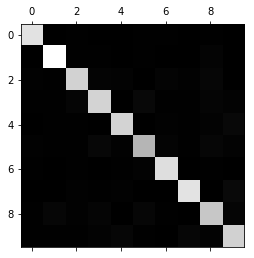

In [14]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

꽤나 괜찮아 보인다. diagonal에 대부분 위치해 있기 때문이다. 하지만 5는 조금 더 검은데, 이는 5를 잘 분류하지 못했다는 뜻이다. 이는 애초에 데이터셋 자체에 5가 별로 없을수도 있거나 혹은 분류기가 분류를 잘 하지 못했을 수도 있다는 뜻이다. 

먼저 confusion matrix의 각 값을 거기에 해당하는 클래스 이미지의 수로 나눠 error rate을 확인할 수 있도록 만들어 보자.

In [15]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [16]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

diagonal은 0으로 채우고 그려 보자.(에러만 보기 위해)

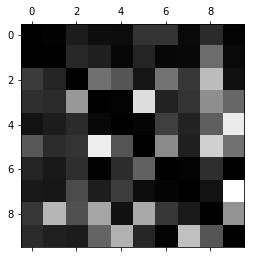

In [17]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

여기서 행이 실제 클래스, 열이 예측된 클래스이다. 보면 8-9를 헷갈려 한다는 걸 알수 있다. 또한 1은 거의 다 잘 분류하고 있다. 이런 것들을 잘 관찰해 어떤 분류기를 더 향상시켜야 할지 알 수 있다. 해당 숫자에 관한 더 많은 훈련 데이터를 모을 수도 있고, 또 새로운 feature를 만들 수도 있다(closed loop 계산하는 알고리즘 - 8은 두개, 5는 0개.) 혹은 이미지를 전처리 할수도 있다.

개별 에러를 분석하는 것 또한 좋은 방법이다. 하지만 이는 시간이 오래 걸리고 어렵다.

In [18]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) #?????
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)

plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) 
plt.show()

NameError: name 'plot_digits' is not defined

<img src="ch3_1.png" alt="Drawing" style="width: 700px;"/>

왼쪽에 있는 블록 두개는 3으로 예측된 것들, 오른쪽은 5로 예측된 것들이다. 딱봐도 글씨를 너무 못써서 사람도 알아보기 힘들다. 하지만 왜 분류기가 이런 실수를 저질렀는지는 알기 힘들다. 이유는 우리가 심플한 SGDClassifier를 써서 그렇다. 이는 각 픽셀에 각 클래스에 해당하는 weight를 주어 놓고 이미지를 보면 바로 weighted pixel를 각 클래스를 예측하는데 사용한다. 하지만 3과 5는 몇 픽셀차이 나지 않아, 오분류 가능성이 높은 것이다. 이런 가능성을 낮추려면 이미지들을 센터에 잘 배열하고 rotate 되어있지 않게 하는 것이다. 

## Multilabel Classification

각 인스턴트들이 여러개의 클래스를 가질 수 있다. 만약 안면인식 분류기가 있다고 치자. 같은 사진에서 여러 사람을 인식할수 있게 하려면 어떻게 해야 할까? 당연히 인식하는 각각의 사람마다 하나의 라벨이 있어야 할 것이다. 만약 우진, 유진, 우신 세명의 얼굴을 인식하는 분류기가 있다고 치자. 우진과 우신의 얼굴을 보여주면 이는 [1,0,1] 아웃풋을 낼 것이다. 이런 것을 Multilabel classification 이라 부른다.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7 )
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
knn_clf.predict([some_digit])

array([[False, False]], dtype=bool)

이런 멀티라벨 분류기를 평가하는 방법은 여러가지가 있고, 그건 프로젝트마다 다르다. 예를 들어 F_1 score을 각 라벨에 계산해 평균 점수를 내는 법이 있다. 

In [ ]:
from sklearn.metrics import f1_score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

이는 모든 라벨이 동등하게 중요함을 가정한다. weight를 주는 방법은 average="weighted"로 주는 것이다.

## Multioutput Classification

이는 멀티라벨 모델에서 각 라벨이 multiclass인 상황을 의미한다. 이미지에서 노이즈를 제거하는 시스템을 생각해 보자. 인풋으로는 noisy digit image가 주어지고, 아웃풋은 깔끔한 이미지여야 한다. 여기서 분류기의 아웃풋은 멀티라벨(한 픽셀에 여러 라벨)이고 각 라벨은 multiple value를 가진다(0~255). 

In [ ]:
import random as rnd

noise = rnd.randint(0, 100, (len(X_train), 784))
noise = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

<img src="ch3_2.png" alt="Drawing" style="width: 500px;"/>

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

<img src="ch3_3.png" alt="Drawing" style="width: 300px;"/>